In [16]:
%load_ext autoreload
%autoreload 2
import sys
import os
import numpy as np

sys.path.append(os.path.abspath('../../Cochlear_Implant_Hackathon/'))

from software.fitness_functions.delta_wav import compute_wavfile_delta,wavefile_MSE,wavefile_correlation,wavefile_max_xcor
# Import the rest of the GpyT subpackage functions for the demo here

from software.AB_imports.Demo.proceduralDemo import demo4_procedural
from scipy.fftpack import fft,rfft,irfft,ifft
from sklearn.preprocessing import StandardScaler
import pyaudio as pa
from scipy.signal import resample
from scipy.io.wavfile import read as wavread
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
try:
    plt.style.use('rossidata')
except:
    pass
from glob import glob
import networkx as nx
from networkx.drawing.nx_agraph import graphviz_layout


The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [2]:
from software.models.gp_model import *
import random
from deap import algorithms, base, creator, tools, gp
import operator

In [3]:
import random
from deap import algorithms, base, creator, tools, gp
import operator


fw = FitnessWrapper(os.path.abspath('../sample_data/sentence1_55_clean.wav'))

og_vect=VectorClass(fw.prepped_data)

og_mat=MatrixClass(np.vstack([fw.prepped_data]*16))

def round_up_to_odd(f):
    return int(np.ceil(f) // 2 * 2 + 1)

def vector_medfilter(vc, integer):
    ## requires odd integers
    oddint=round_up_to_odd(integer)

    vc.data = medfilt(vc.data, oddint)
    return vc


def vector_multiply(vc,x):
    if x is not None:
        vc.data=np.multiply(vc.data,x)
        return vc
    else:
        return vc

def vector_divide(vc,x):
    if x is not None:
        vc.data=np.divide(vc.data,x)
        return vc
    else:
        return vc

def norm_vector_convolve(vc1,vc2):
    convolved=convolve(vc1.data, vc2.data, mode='same')
    convolved/=np.max(convolved)
    convolved*=max(vc2.data)
    vc1.data=convolved
    return vc1

def norm_hilbert(vc):
    vc.data=np.abs((hilbert(vc.data)))
    return vc


def vector_add(vc1,vc2):
    vc1.data = np.add(vc1.data, vc2.data)
    return vc1

def vector_subtract(vc1,vc2):
    vc1.data = np.subtract(vc1.data, vc2.data)
    return vc1


def pass_primitive(x):

    return x

pset = gp.PrimitiveSetTyped("MAIN", [VectorClass],MatrixClass)
pset.addPrimitive(MatrixClass.create_matrix,list(itertools.repeat(VectorClass, 16)),MatrixClass)


### vector vector primitives
pset.addPrimitive(norm_vector_convolve,[VectorClass,VectorClass],VectorClass)
# pset.addPrimitive(vector_add,[VectorClass,VectorClass],VectorClass)
# pset.addPrimitive(vector_subtract,[VectorClass,VectorClass],VectorClass)

### vector value primitives
pset.addPrimitive(vector_multiply, [VectorClass,float], VectorClass)
pset.addPrimitive(norm_hilbert,[VectorClass],VectorClass)
#pset.addPrimitive(vector_divide, [VectorClass,float], VectorClass)

pset.addPrimitive(vector_medfilter,[VectorClass,int],VectorClass)
pset.addPrimitive(pass_primitive,[int],int)
pset.addPrimitive(pass_primitive,[float],float)

### value value primitives
pset.addPrimitive(operator.neg, [float],float)
pset.addPrimitive(operator.neg, [float],float)


### ephermerals and terminals
pset.addTerminal(og_mat,MatrixClass)
pset.addEphemeralConstant("rand_int", lambda: random.randrange(1, 101+1, 20), int)
pset.addEphemeralConstant("uniform", lambda: random.uniform(0.5, 1.5), float)

pset.renameArguments(ARG0="input_audio")


creator.create("FitnessMax", base.Fitness, weights=(1.0,))
creator.create("Individual", gp.PrimitiveTree, fitness=creator.FitnessMax)

toolbox = base.Toolbox()
toolbox.register("expr_init", gp.genFull, pset=pset, min_=1, max_=3)
#pool = multiprocessing.Pool()
#toolbox.register("map", pool.map)

# toolbox.register("map", futures.map)

# Structure initializers
toolbox.register("individual", tools.initIterate, creator.Individual, toolbox.expr_init)
toolbox.register("population", tools.initRepeat, list, toolbox.individual)
toolbox.register("compile", gp.compile, pset=pset)


def evalSymbTransform(individual, fw):
    ## investigate with gp.graph(individual)

    transform = toolbox.compile(expr=individual)
    score = fw.score_new_transform(transform,traceback=individual)
    return score,


toolbox.register("evaluate", evalSymbTransform, fw=fw)
toolbox.register("select", tools.selTournament, tournsize=3)
toolbox.register("mate", gp.cxOnePoint)
toolbox.register("expr_mut", gp.genFull, min_=0, max_=3)
toolbox.register("mutate", gp.mutUniform, expr=toolbox.expr_mut, pset=pset)

toolbox.decorate("mate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))
toolbox.decorate("mutate", gp.staticLimit(key=operator.attrgetter("height"), max_value=17))

stats_fit = tools.Statistics(lambda ind: ind.fitness.values)
stats_size = tools.Statistics(len)
mstats = tools.MultiStatistics(fitness=stats_fit, size=stats_size)
mstats.register("avg", np.mean)
mstats.register("std", np.std)
mstats.register("min", np.min)
mstats.register("max", np.max)

pop = toolbox.population(n=50)
hof = tools.HallOfFame(5)

In [4]:
sorted(glob('../results/*.pkl'))#[-1]

['../results/results_2021_01_02_053813.pkl',
 '../results/results_2021_01_02_053831.pkl',
 '../results/results_2021_01_03_102424.pkl',
 '../results/results_2021_01_03_112923.pkl',
 '../results/results_2021_01_03_121514.pkl',
 '../results/results_2021_01_04_132215.pkl',
 '../results/results_models_2021_01_05_052315.pkl',
 '../results/results_models_2021_01_05_110515.pkl',
 '../results/results_models_2021_01_05_222442.pkl',
 '../results/results_models_2021_01_06_105933.pkl',
 '../results/results_models_2021_01_06_131920.pkl',
 '../results/results_scores_2021_01_05_052315.pkl',
 '../results/results_scores_2021_01_05_110515.pkl',
 '../results/results_scores_2021_01_05_222442.pkl',
 '../results/results_scores_2021_01_06_105933.pkl',
 '../results/results_scores_2021_01_06_131920.pkl']

In [5]:
most_recent='../results/results_scores_2021_01_06_131920.pkl'

In [6]:

results=pickle.load( open(most_recent, "rb" ) )

In [143]:
results

{'max_result': [<deap.gp.Primitive at 0x18cac0db8>,
  <deap.gp.Terminal at 0x18c03f870>]}

In [7]:
wavefile_max_xcor(results['audio_input'],results['frequency_input'],
                 results['audio_out'],results['frequency_out'])

0.027550958790110134

In [144]:

gp.graph(results['max_result'])

([0,
  1,
  2,
  3,
  4,
  5,
  6,
  7,
  8,
  9,
  10,
  11,
  12,
  13,
  14,
  15,
  16,
  17,
  18,
  19,
  20,
  21,
  22,
  23,
  24,
  25,
  26,
  27,
  28,
  29,
  30,
  31,
  32,
  33,
  34,
  35,
  36,
  37,
  38,
  39,
  40,
  41,
  42,
  43,
  44,
  45,
  46,
  47,
  48,
  49,
  50,
  51,
  52,
  53,
  54,
  55,
  56,
  57,
  58,
  59,
  60,
  61,
  62,
  63,
  64,
  65],
 [(0, 1),
  (1, 2),
  (2, 3),
  (0, 4),
  (4, 5),
  (5, 6),
  (5, 7),
  (0, 8),
  (8, 9),
  (9, 10),
  (0, 11),
  (11, 12),
  (12, 13),
  (0, 14),
  (14, 15),
  (15, 16),
  (14, 17),
  (17, 18),
  (17, 19),
  (0, 20),
  (20, 21),
  (21, 22),
  (0, 23),
  (23, 24),
  (24, 25),
  (24, 26),
  (26, 27),
  (27, 28),
  (26, 29),
  (29, 30),
  (29, 31),
  (0, 32),
  (32, 33),
  (33, 34),
  (0, 35),
  (35, 36),
  (36, 37),
  (36, 38),
  (0, 39),
  (39, 40),
  (40, 41),
  (0, 42),
  (42, 43),
  (43, 44),
  (42, 45),
  (45, 46),
  (45, 47),
  (0, 48),
  (48, 49),
  (49, 50),
  (48, 51),
  (51, 52),
  (0, 53),
  (53,

In [ ]:
import matplotlib.pyplot as plt
import networkx as nx

g = nx.Graph()
g.add_nodes_from(nodes)
g.add_edges_from(edges)
pos = nx.graphviz_layout(g, prog="dot")

nx.draw_networkx_nodes(g, pos)
nx.draw_networkx_edges(g, pos)
nx.draw_networkx_labels(g, pos, labels)
plt.show()

# Rendering Sound Files

In [15]:
# play initial sound file

p = pa.PyAudio()
devInfo = p.get_default_output_device_info()
devIndex = devInfo['index']
nChan = 1

stream = p.open(format=pa.paFloat32,
channels=nChan,
rate=results['frequency_input'],
output=True,
output_device_index = devIndex
)

data=results['audio_input']/(2**15-1)
#data=results['audi']/(2**10-1)
inData = data.astype(np.float32).tobytes()

stream.write(inData)
stream.close()

OSError: [Errno -9986] Internal PortAudio error

In [14]:

p = pa.PyAudio()
devInfo = p.get_default_output_device_info()
devIndex = devInfo['index']
nChan = 1

stream = p.open(format=pa.paFloat32,
channels=nChan,
rate=results['frequency_out'],
output=True,
output_device_index = devIndex
)

data=results['audio_out']#/(2**15-1)
inData = data.astype(np.float32).tobytes()



stream.write(inData)
stream.close()

OSError: [Errno -9986] Internal PortAudio error

In [22]:
compute_wavfile_delta(results['audio_input'],results['frequency_input'],results['audio_out'],results['frequency_out'])



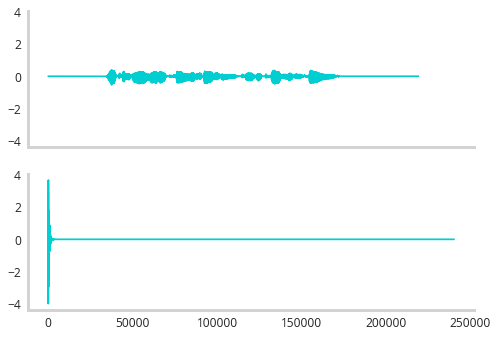

In [114]:
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True,sharey=True)
ax1.plot(results['audio_input'][10000:]/(2**10-1))
ax2.plot(results['audio_out'][10000:]*(2**30-1))

In [115]:
wavefile_correlation(results['audio_input']/(2**15-1),results['frequency_input'],results['audio_out'],results['frequency_out'])

-5.063641704256563e-06

In [41]:
from scipy import signal

In [80]:
fs=results['frequency_input']

fc = 500  # Cut-off frequency of the filter
w = fc / (fs / 2) # Normalize the frequency
b, a = signal.butter(5, w, 'high')
output = signal.filtfilt(b, a, results['audio_input'])

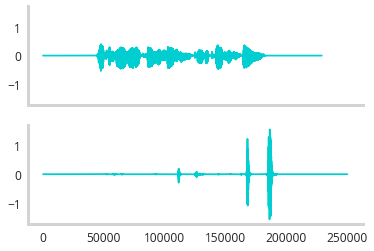

In [8]:
fig,(ax1,ax2)=plt.subplots(2,1,sharex=True,sharey=True)
ax1.plot(results['audio_input']/(2**10-1))
ax2.plot(results['audio_out'])

In [69]:
fw.prepped_rate

In [82]:
results

{'audio_input': array([ 0,  0,  0, ...,  0, -1,  0], dtype=int16),
 'frequency_input': 44100,
 'audio_out': array([0.00000000e+00, 0.00000000e+00, 0.00000000e+00, ...,
        3.03277329e-53, 2.70462717e-53, 2.33747588e-53]),
 'frequency_out': 48161,
 'score': 0.02106869141973069}

In [138]:
wavefile_max_xcor(results['audio_input'],results['frequency_input'],results['audio_out'],results['frequency_out'])



1.4097153020730177e-05

In [134]:
ref_remastered = convert_sample_rate(results['audio_input'],results['frequency_input'])
output_remastered = convert_sample_rate(results['audio_out'],results['frequency_out'])
min_len=min([len(ref_remastered),len(output_remastered)])

a=ref_remastered[:min_len]
b=ref_remastered[:min_len]
a = (a - np.mean(a)) / (np.std(a) * len(a))
b = (b - np.mean(b)) / (np.std(b))
c = np.correlate(a, b, 'full')

# only comparing with slight offset


In [137]:
max(c[min_len-1000:min_len+1000])

1.0000000000000007

83187